# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal
### Projet A2024
----
Équipe T - TODO
### Objectif
Prédiction de **la consommation en carburant de voitures récentes**.

### Données
Le jeu de données contient pour presque 400 véhicule, la consommation moyenne en L/100km, l'année de frabrication, le type de véhicule, le nombre de cylindre, cylindree, la transmission et la boite.

- `train.csv` est l'ensemble d'entraînement
- `test.csv` est l'ensemble de test


## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [411]:
#= import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DecisionTree") =#

In [412]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree,Random, Plots

In [413]:
function standardize(data)
    return (data .- mean(data)) ./ std(data)
end

function standardize_data(data)
    stddata = deepcopy(data)
   for col in names(stddata)
        if eltype(stddata[!, col]) <: Number && col != "id"
            stddata[!, col] = standardize(stddata[!, col])
        end
    end
    return stddata
end

standardize_data (generic function with 1 method)

In [414]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :general_type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return encoded_data
end

encode_data (generic function with 1 method)

In [415]:
function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :general_type]))
end

removeRows (generic function with 1 method)

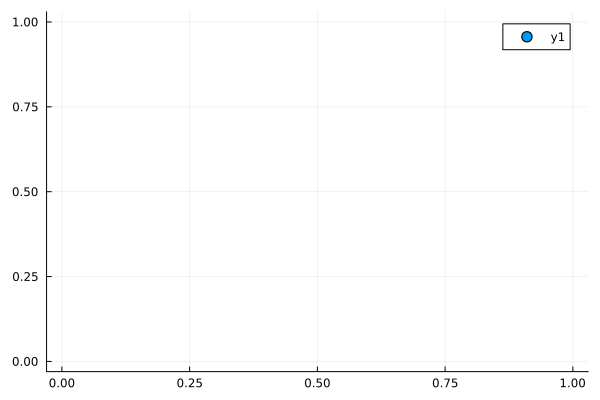

In [416]:
d = trainData[trainData.type .== "voiture_deux_places", :]

scatter(d.nombre_cylindres, d.consommation)

In [466]:
function add_general_type(data :: DataFrame)
    data = deepcopy(data)
    general_type_dict = Dict("voiture_moyenne" => "voiture", "VUS_petit" => "VUS", "voiture_compacte" => "voiture", "voiture_deux_places" => "voiture", "voiture_minicompacte" => "voiture", "VUS_standard" => "VUS", "monospace" => "camionnette", "voiture_sous_compacte" => "voiture", "camionnette_petit" => "camionnette", "break_petit" => "break", "voiture_grande" => "voiture", "camionnette_standard" => "camionnette", "break_moyen" => "break", "voiture_sport" => "voiture_sport")
    
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    data.type = ifelse.(data.type .== "voiture_deux_places"   .&& data.boite.=="manuelle" .&& data.cylindree .>= 4 , "voiture_sport" , data.type)

    #= println(sum(data.type .== "voiture_deux_places" .&& data.volume_gaz .> 45 .&& data.transmission .== "integrale" )) =#

    data.general_type = [general_type_dict[t] for t in data.type]
    return data
end



add_general_type (generic function with 1 method)

In [465]:
sort(d[d.general_type .== "voiture_sport", :], :consommation, rev=true)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,id,volume_gaz,general_type
,Int64,Abstract…,Int64,Float64,String15,String15,Float64,Int64,Float64,String
1,2014,voiture_sport,8,4.2,integrale,manuelle,16.8007,64,33.6,voiture_sport
2,2014,voiture_sport,8,4.2,integrale,manuelle,16.8007,358,33.6,voiture_sport
3,2019,voiture_sport,8,6.2,propulsion,manuelle,13.8359,135,49.6,voiture_sport
4,2017,voiture_sport,6,3.0,propulsion,manuelle,13.0672,190,18.0,voiture_sport
5,2017,voiture_sport,6,3.0,propulsion,manuelle,13.0672,294,18.0,voiture_sport
6,2017,voiture_sport,6,3.0,propulsion,manuelle,12.3795,82,18.0,voiture_sport
7,2019,voiture_sport,8,6.2,propulsion,manuelle,12.3795,93,49.6,voiture_sport


In [467]:
d= add_general_type(trainData)
println(mean(d[d.general_type .== "voiture_sport", :].consommation))
sort(d[d.general_type .== "voiture_sport", :], :consommation, rev=true)

14.954196152145075


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,id,volume_gaz,general_type
,Int64,Abstract…,Int64,Float64,String15,String15,Float64,Int64,Float64,String
1,2014,voiture_sport,8,4.2,integrale,manuelle,16.8007,64,33.6,voiture_sport
2,2014,voiture_sport,8,4.2,integrale,manuelle,16.8007,358,33.6,voiture_sport
3,2019,voiture_sport,8,6.2,propulsion,manuelle,13.8359,135,49.6,voiture_sport
4,2019,voiture_sport,8,6.2,propulsion,manuelle,12.3795,93,49.6,voiture_sport


In [360]:
add_general_type(testData)[testData.general_type .== "voiture_sport", :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,id,volume_gaz,general_type
,Int64,Abstract…,Int64,Float64,String15,String15,Int64,Float64,String
1,2014,voiture_sport,10,5.2,integrale,manuelle,10,52.0,voiture_sport
2,2014,voiture_sport,10,5.2,integrale,manuelle,11,52.0,voiture_sport
3,2019,voiture_sport,8,6.2,propulsion,manuelle,92,49.6,voiture_sport


In [505]:
function add_rows(data)
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    # https://www.insurancenavy.com/average-car-weight/
    # https://www.auto-tests.com/fr/lightest-weight/Wagon/all/
    weight_dict = Dict("voiture_moyenne" => 3300, "VUS_petit" => 3500, "voiture_compacte" => 2800, "voiture_deux_places" => 2800, "voiture_minicompacte" => 1500, "VUS_standard" => 5000, "monospace" => 4500, "voiture_sous_compacte" => 2600, "camionnette_petit" => 4200, "break_petit" => 2640, "voiture_grande" => 4400, "camionnette_standard" => 4700, "break_moyen" => 3300)
    data[!, :weight] = [weight_dict[t] for t in data[!, :type]]

    data = add_general_type(data)
    
    # display(plot(data, x=:general_type, y=:consommation, color=:type))
    # println(combine(groupby(data, :type), nrow => :count))
    return data
end

add_rows (generic function with 1 method)

In [324]:
function getStandardEncodedData(data)
    data_copy = deepcopy(data)
    standardised_data = add_rows(data_copy)
    standardised_data = standardize_data(data_copy)
    # standardised_data = encode_data(standardised_data)
    standardised_data = removeRows(standardised_data)
    return standardised_data
end

    



getStandardEncodedData (generic function with 1 method)

In [325]:
function rmse(y, ychap)
    return sqrt(mean((ychap .- y).^2))
end


rmse (generic function with 1 method)

In [326]:
function rsquared(y, ychap)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- ychap).^2)
    return ss_res / ss_total
end


rsquared (generic function with 1 method)

In [327]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [419]:
trainData = CSV.read("../../data/train.csv", DataFrame)
testData = CSV.read("../../data/test.csv", DataFrame)
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))
testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))


COMSOMMATION_MEAN = mean(trainData.consommation)
COMSOMMATION_STD = std(trainData.consommation)
trainData[!, :id] = 1:nrow(trainData)
testData[!, :id] = 1:nrow(testData)

possibles = unique(trainData.consommation)


25-element Vector{Float64}:
 13.8358823529412
  9.80041666666667
 11.7605
 13.0672222222222
  7.3503125
  7.58741935483871
 11.2004761904762
 14.700625
 12.3794736842105
 10.6913636363636
  9.4084
 15.6806666666667
  8.71148148148148
  8.11068965517241
 10.2265217391304
  7.84033333333333
  8.40035714285714
  9.04653846153846
 16.8007142857143
  6.91794117647059
  6.35702702702703
  4.52326923076923
  7.12757575757576
  4.90020833333333
  6.53361111111111

In [329]:
function evaluate_rmse(data)
    nrange = 1000
    n = 0
    for i in range(0, 1, length=nrange)
        n += regression(data)[1]
    end
    print("average rmse for regression: ", n/nrange, "\n")
end


evaluate_rmse (generic function with 1 method)

In [330]:
function remise(prediction)
    id = 1:150
    df_pred = DataFrame(id=id, consommation=prediction)

   format_file(df_pred)
end

function format_file(predictions,i)
    #println(predictions)
    current_time = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    file_name = "benchmark_$i.csv"
    CSV.write("./" *file_name, predictions)
end

format_file (generic function with 1 method)

In [331]:
# findnearest(A::Vector{Float64},t::Float64) = A[findmin(broadcast(abs,A.-t))[2]]

# function findnearest(A::Vector{Float64},t::Float64)
#     nearest_value = A[1]
#     smallest_diff = abs(A[1] - t)
#     for value in A
#         diff = abs(value - t)
#         if diff < smallest_diff
#             smallest_diff = diff
#             nearest_value = value
#         end
#     end
#     if smallest_diff > 0.3
#         # println("Warning: the nearest value is ", nearest_value, " the value was ", t," with a difference of ", smallest_diff)
#     end
#     return nearest_value
    
# end


In [332]:
getStandardEncodedData(trainData)

Row,annee,nombre_cylindres,cylindree,consommation,id,volume_gaz,weight
,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,1.18235,1.55182,1.24022,1.62592,1,1.35681,0.181465
2,0.250279,-0.734771,-0.748147,-0.260021,2,-0.708458,0.452737
3,0.560971,0.408527,0.328884,0.656007,3,0.187502,-0.496716
4,1.18235,1.55182,1.73731,1.26669,4,1.72126,-0.496716
5,0.871662,1.55182,1.24022,1.62592,5,1.35681,0.181465
6,0.871662,1.55182,1.24022,1.62592,6,1.35681,0.181465
7,0.871662,-1.30642,-1.16239,-1.40506,7,-0.974209,-2.25999
8,1.49304,-1.30642,-1.16239,-1.29425,8,-0.974209,-2.25999
9,0.250279,0.408527,0.743126,0.394284,9,0.415288,2.48728


In [333]:
function get_unique_data(data, columns_to_compare)
    unique_data = combine(groupby(data, columns_to_compare), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
#=     unique_data = add_rows(unique_data)
 =#    return unique_data
end

function find_pairs(data_train, data_predict, columns_to_compare)
    train_data_without_consommation = select(data_train, Not(:consommation))
    # print(train_data_without_consommation)
    predict_data_without_annee = select(data_predict, Not(:annee))
    # print(predict_data_without_annee)

    #println(names(train_data_without_consommation))

    common_values = innerjoin(data_train, data_predict, on=columns_to_compare)

    #println(common_values.id)
    # print(common_values)
    return common_values
end

function find_differents(data_train, data_predict)
    different_values = antijoin(data_predict, data_train, on=COLUMNS_TO_COMPARE)
    return different_values
    
end

function predict_with_dups(data_train, data_predict, raw_data_train, raw_data_predict)
    pairs = find_pairs(raw_data_train, raw_data_predict)
    pairs = select(pairs, [:id, :consommation])

    different_values = find_differents(raw_data_train, raw_data_predict)
    # println(different_values)

    beta = regression(data_train, 0.0)[2]

    data_predict = getStandardEncodedData(different_values[!, Not(:id)])


    data_predict = Matrix(data_predict[:, names(data_train[:, Not(:consommation)])])
    println(data_predict)

    prediction_differents = data_predict * beta


    prediction_differents = (prediction_differents .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN

    prediction_differents = DataFrame(id=different_values.id, consommation=prediction_differents)

    # print(prediction_differents)
    # print(pairs)

    prediction = vcat(pairs, prediction_differents)
    prediction = sort(prediction, :id)
    # println(prediction)

    # print(prediction)
    return prediction
end
    
    

predict_with_dups (generic function with 1 method)

In [334]:
function linear_regression(data, x_col, y_col)
    # Extract x and y data from the DataFrame
    x = data[!, x_col]
    y = data[!, y_col]
    
    # Ensure there is enough data for the calculation
    n = length(x)
    if n == 0
        error("Cannot compute linear regression with zero elements.")
    end
    
    # Calculate the mean values
    x_mean = mean(x)
    y_mean = mean(y)
    
    # Calculate slope and intercept for linear regression
    slope = sum((x .- x_mean) .* (y .- y_mean)) / sum((x .- x_mean).^2)
    intercept = y_mean - slope * x_mean
    
    return slope, intercept
end

linear_regression (generic function with 1 method)

In [335]:

function get_outliers_ind_regression_lin(data, x_col, y_col; threshold=2.5)
    slope, intercept = linear_regression(data, x_col, y_col)
    
    x = data[!, x_col]
    y = data[!, y_col]
    
    y_pred = slope .* x .+ intercept
    
    residuals = abs.(y .- y_pred)
    
    residuals_std = std(residuals)
    
    outlier_indices = findall(residuals .> threshold * residuals_std)
    

    for idx in outlier_indices
        # println("Outlier detected at row $idx: ", "x = ", x[idx], ", y = ", y[idx], ", Residual = ", residuals[idx])
    end

    outliers = data[outlier_indices, :]
    
    return outlier_indices
end


get_outliers_ind_regression_lin (generic function with 1 method)

In [336]:
function get_outliers_regression_lin(data, outliers_indices)
    outliers = data[outliers_indices, :]
    return outliers
end;

In [337]:
function remove_outliers_regression_lin(data::DataFrame, x_col::Symbol, y_col::Symbol; threshold=2.5)
    outlier_indices = get_outliers_ind_regression_lin(data, x_col, y_col, threshold=threshold)

    # println("Outlier Indices Identified: ", outlier_indices)

    keep_mask = trues(nrow(data))
    
    if !isempty(outlier_indices)
        keep_mask[outlier_indices] .= false
    end

    cleaned_data = data[keep_mask, :]
    
    return cleaned_data
end

remove_outliers_regression_lin (generic function with 1 method)

In [338]:
 function plot_outliers(uniqueD)
 # Step 2: Find and Display Outliers with Regression
 outliers_indices = get_outliers_ind_regression_lin(uniqueD, :cylindree, :consommation)
 outliers_regression = get_outliers_regression_lin(uniqueD, outliers_indices)

 # Step 3: Plot Original Data, Regression Line, and Outliers
 slope, intercept = linear_regression(uniqueD, :cylindree, :consommation)
 regression_line_y = slope .* uniqueD.cylindree .+ intercept

 layer_original = layer(x=uniqueD.cylindree, y=uniqueD.consommation, color=uniqueD.type, Theme(default_color="blue"))
 layer_linear_regression = layer(x=uniqueD.cylindree, y=regression_line_y, Geom.line, Theme(default_color="green"))
 layer_regression_outliers = layer(x=outliers_regression.cylindree, y=outliers_regression.consommation, Geom.point, Theme(default_color="red"))

 
 display(plot(layer_regression_outliers, layer_original, layer_linear_regression, Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Original Data with Outliers")))

 # Step 4: Remove Outliers Based on Regression Line
 cleaned_data = remove_outliers_regression_lin(uniqueD, :cylindree, :consommation, threshold=2.5)

 # Step 5: Plot Cleaned Data with New Regression Line
 slope_cleaned, intercept_cleaned = linear_regression(cleaned_data, :cylindree, :consommation)
 regression_line_y_cleaned = slope_cleaned .* cleaned_data.cylindree .+ intercept_cleaned

layer_cleaned = layer(x=cleaned_data.cylindree, y=cleaned_data.consommation, color=cleaned_data.type, Theme(default_color="blue"))
layer_linear_regression_cleaned = layer(x=cleaned_data.cylindree, y=regression_line_y_cleaned, Geom.line, Theme(default_color="green"))

# Display plot for cleaned data
display(plot(layer_cleaned, layer_linear_regression_cleaned, 
             Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Cleaned Data with Regression Line")))

end

plot_outliers (generic function with 1 method)

In [339]:
function regression(standardised_data, trainTestSplitPercentage = 0.2)
    training_data, test_data = train_test_split(standardised_data, trainTestSplitPercentage)

    X_train =  Matrix(training_data[:, Not(:consommation)])
    y_train = training_data[:, :consommation]

    beta = X_train \ y_train

    rmseval = 0.0
    if trainTestSplitPercentage != 0.0
        X_test = Matrix(test_data[:, Not(:consommation)])
        y_test = test_data[:, :consommation]
        ychap =  X_test * beta
        ychap = (ychap .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        rmseval = rmse(y_test, ychap)
    end
    
    return rmseval, beta, training_data, test_data
end

regression (generic function with 2 methods)

In [340]:
function remise_regression(beta)
    test_data = getStandardEncodedData(testData)
    X_test = Matrix(test_data[!,Not(:id)])
    ychap =  X_test * beta
    # ychap = (ychap .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    remise(ychap)
end


remise_regression (generic function with 1 method)

In [506]:
d= add_rows(trainData)
d = encode_data(d)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,id,volume_gaz,weight,general_type,voiture,VUS,camionnette,break,voiture_sport,integrale,propulsion,traction,4x4,automatique,manuelle
,Int64,Abstract…,Int64,Float64,String15,String15,Float64,Int64,Float64,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2023,voiture_moyenne,8,4.4,integrale,automatique,13.8359,1,35.2,3300,voiture,1,0,0,0,0,1,0,0,0,1,0
2,2020,VUS_petit,4,2.0,integrale,automatique,9.80042,2,8.0,3500,VUS,0,1,0,0,0,1,0,0,0,1,0
3,2021,voiture_compacte,6,3.3,propulsion,automatique,11.7605,3,19.8,2800,voiture,1,0,0,0,0,0,1,0,0,1,0
4,2023,voiture_deux_places,8,5.0,integrale,automatique,13.0672,4,40.0,2800,voiture,1,0,0,0,0,1,0,0,0,1,0
5,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359,5,35.2,3300,voiture,1,0,0,0,0,1,0,0,0,1,0
6,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359,6,35.2,3300,voiture,1,0,0,0,0,1,0,0,0,1,0
7,2022,voiture_minicompacte,3,1.5,traction,automatique,7.35031,7,4.5,1500,voiture,1,0,0,0,0,0,0,1,0,1,0
8,2024,voiture_minicompacte,3,1.5,traction,manuelle,7.58742,8,4.5,1500,voiture,1,0,0,0,0,0,0,1,0,0,1
9,2020,VUS_standard,6,3.8,integrale,automatique,11.2005,9,22.8,5000,VUS,0,1,0,0,0,1,0,0,0,1,0


In [507]:
d = removeRows(d)

Row,annee,nombre_cylindres,cylindree,consommation,id,volume_gaz,weight,voiture,VUS,camionnette,break,voiture_sport,integrale,propulsion,traction,4x4,automatique,manuelle
,Int64,Int64,Float64,Float64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2023,8,4.4,13.8359,1,35.2,3300,1,0,0,0,0,1,0,0,0,1,0
2,2020,4,2.0,9.80042,2,8.0,3500,0,1,0,0,0,1,0,0,0,1,0
3,2021,6,3.3,11.7605,3,19.8,2800,1,0,0,0,0,0,1,0,0,1,0
4,2023,8,5.0,13.0672,4,40.0,2800,1,0,0,0,0,1,0,0,0,1,0
5,2022,8,4.4,13.8359,5,35.2,3300,1,0,0,0,0,1,0,0,0,1,0
6,2022,8,4.4,13.8359,6,35.2,3300,1,0,0,0,0,1,0,0,0,1,0
7,2022,3,1.5,7.35031,7,4.5,1500,1,0,0,0,0,0,0,1,0,1,0
8,2024,3,1.5,7.58742,8,4.5,1500,1,0,0,0,0,0,0,1,0,0,1
9,2020,6,3.8,11.2005,9,22.8,5000,0,1,0,0,0,1,0,0,0,1,0


In [529]:
using LinearAlgebra

function fit_ridge_regression(X::DataFrame, y::Vector, lambda::Float64)
    X = mapcols(x -> (x.-mean(x))/std(x), X)
    X = Matrix(X)
    beta = (X'X + lambda * I) \ (X'y)
    return beta
end

# Example usage
lambda = 0.3

beta = fit_ridge_regression(d[:, Not(:consommation, :id)], d.consommation, lambda)
betas = DataFrame(colnames=names(d[:, Not(:consommation, :id)]), beta=beta, abs=abs.(beta))

colToIndex = Dict("cylindree" => "cylindree", "nombre_cylindres" => "nombre_cylindres", "volume_gaz" => "volume_gaz", "weight" => "weight", "voiture" => "general_type", "VUS" => "general_type", "voiture_sport" => "general_type", "camionnette" => "general_type", "break" => "general_type", "manuelle" => "boite", "automatique" => "boite", "integrale" => "transmission", "traction" => "transmission", "propulsion" => "transmission", "4x4" => "transmission", "annee" => "annee")

betas.colType = [colToIndex[c] for c in betas.colnames]

combined_betas = combine(groupby(betas, :colType), :abs => maximum)

#= filtered_betas = filter(row -> row.colType in, combined_betas)
 =#
sort(combined_betas, :abs_maximum, rev=true)

Row,colType,abs_maximum
,String,Float64
1,cylindree,1.0133
2,nombre_cylindres,0.996866
3,transmission,0.329464
4,volume_gaz,0.30483
5,general_type,0.187735
6,boite,0.0878455
7,weight,0.0497366
8,annee,0.00390767


In [524]:
COLUMNS_TO_COMPARE_0 = ["type", "nombre_cylindres", "cylindree", "transmission", "boite", "annee"]
COLUMNS_TO_COMPARE_1 = ["type", "nombre_cylindres", "cylindree", "transmission", "boite"]
COLUMNS_TO_COMPARE_2 = ["nombre_cylindres", "cylindree", "transmission", "general_type" ]
COLUMNS_TO_COMPARE_3 = ["nombre_cylindres", "cylindree"]
COLUMNS_TO_COMPARE_4 = ["cylindree"]
COLUMNS_TO_COMPARE_5 = ["cylindree"]

function main(testData)
    #= uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_1)
    pairs = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_1)
    pairs = select(pairs, [:id, :consommation])
    testData = filter(row -> !(row.id in pairs.id), testData) =#

    #= uniqueD = get_unique_data(uniqueD, COLUMNS_TO_COMPARE_1)
    pairs_1 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_1)
    pairs_1 = select(pairs_1, [:id, :consommation])
    pairs = vcat(pairs, pairs_1)
    testData = filter(row -> !(row.id in pairs.id), testData) =#

    uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_1)
    pairs = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_1)
    pairs = select(pairs, [:id, :consommation])
    testData = filter(row -> !(row.id in pairs.id), testData)

    #= uniqueD = get_unique_data(uniqueD, COLUMNS_TO_COMPARE_2)
    uniqueD.transmission = [replace(t, "traction" => "integrale", ) for t in uniqueD.transmission]
    pairs_2 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_2)
    pairs_2 = select(pairs_2, [:id, :consommation])
    pairs_official = pairs
    pairs = vcat(pairs, pairs_2)
    testData = filter(row -> !(row.id in pairs.id), testData)
 =#
     

    #= uniqueD = get_unique_data(uniqueD, COLUMNS_TO_COMPARE_2)  
    uniqueD.transmission = [replace(t, "traction" => "integrale", ) for t in uniqueD.transmission]
    pairs_2_5 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_2)
    pairs_2_5 = select(pairs_2_5, [:id, :consommation])
    pairs_official = pairs
    pairs = vcat(pairs, pairs_2_5)
    testData = filter(row -> !(row.id in pairs.id), testData) =#

#=     return pairs_2_5
 =#



    uniqueD = add_general_type(trainData)
    testData = add_general_type(testData)
    uniqueD = get_unique_data(uniqueD, COLUMNS_TO_COMPARE_3)
#= return uniqueD[uniqueD.general_type .== "voiture_sport", :]
 =#  pairs_3 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_3)
    pairs_3 = select(pairs_3, [:id, :consommation])
    pairs = vcat(pairs, pairs_3)
    testData = filter(row -> !(row.id in pairs.id), testData)


    uniqueD = get_unique_data(uniqueD, COLUMNS_TO_COMPARE_4)
    pairs_4 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_4)
    pairs_4 = select(pairs_4, [:id, :consommation])
    pairs = vcat(pairs, pairs_4)
    testData = filter(row -> !(row.id in pairs.id), testData)

    average= (15.6806666666667 + 13.8358823529412)/2 
    pairs_5 = DataFrame(id=5, consommation=average)
    pairs = vcat(pairs, pairs_5)
    testData = filter(row -> !(row.id in pairs.id), testData) 
    # print(testData)

    # vcat(pairs_1, pairs_2, pairs_3, pairs_4, pairs_5)

    # println(pairs_2.id)

    sort!(pairs, :id)

    format_file(pairs,20)

    return pairs
#= 
    data_1 = CSV.read("../soumission_2/benchmark1.csv", DataFrame)

    rows_in_data_1 = filter(row -> !(row.id in pairs.id), data_1)
    # println(rows_in_data_1)
    

    pairs_official = vcat(pairs, rows_in_data_1)


    sort!(pairs_official, :id)

    # println(pairs_official)

    # print(pairs)

    format_file(pairs_official,1)

    # uniqueD = remove_outliers_regression_lin(uniqueD, :cylindree, :consommation, threshold=2.5)

    # unique_standard = getStandardEncodedData(uniqueD)
    # predictStandard = getStandardEncodedData(testData)
    # evaluate_rmse(uniqueD)

    # println(uniqueD)
    # println(predictStandard)


    # format_file(predict_with_dups(unique_standard, predictStandard, uniqueD, testData))


    # predict_with_dups(unique_standard, predictStandard, uniqueD, testData)
    # format_file(predict_with_dups(uniqueD, testData))
  =#
end
out = main(testData)

Row,id,consommation
,Int64,Float64
1,1,8.11069
2,2,7.59532
3,3,8.66848
4,4,8.71148
5,5,14.7583
6,6,13.8359
7,7,13.8359
8,8,10.2265
9,9,10.9459


In [523]:
testData[5, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,id
,Int64,String31,Int64,Float64,String15,String15,Int64
5,2014,voiture_sous_compacte,8,5.8,propulsion,manuelle,5


In [471]:
out[[10,11], :]

Row,id,consommation
,Int64,Float64
1,10,14.4124
2,11,14.4124


In [345]:
data_13 = CSV.read("./benchmark13.csv", DataFrame)

Row,id,consommation
,Int64,Float64
1,1,8.11069
2,2,7.59532
3,3,8.66848
4,4,8.71148
5,5,14.7583
6,6,13.8359
7,7,13.8359
8,8,10.2265
9,9,10.9459


In [346]:
uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_1)
uniqueD[ uniqueD.type .== "voiture_deux_places", : ]

#sort(trainData, :consommation, rev=true)

#essayer, plutot que d'enlever une colonne automatiquement, essayer de réduire le nb d'états possibles, ex : integrale => propulsion 

Row,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Abstract…,Int64,Float64,String15,String15,Float64
1,voiture_deux_places,8,5.0,integrale,automatique,13.0672
2,voiture_deux_places,6,3.0,propulsion,automatique,10.5223
3,voiture_deux_places,6,3.0,integrale,automatique,11.2005
4,voiture_deux_places,8,4.2,integrale,automatique,13.8359
5,voiture_deux_places,4,2.0,propulsion,automatique,9.04654
6,voiture_deux_places,8,5.0,propulsion,automatique,12.6546
7,voiture_deux_places,8,4.2,integrale,manuelle,16.8007
8,voiture_deux_places,6,3.0,propulsion,manuelle,12.838
9,voiture_deux_places,4,2.0,integrale,automatique,9.04654


In [347]:
diffs = testData[differentIds, :]
diffs.commentaires = repeat([""], nrow(diffs))
diffs.commentaires[1] = "un cas extreme de voiture 2 places que 3 que je peux remarquer dans le dataset"
diffs.commentaires[2] = "meme chose que 1, on pourrait trouver que ce sont des cas extremes et donc les traiter differement"
leftjoin(diffs, data_13, on=:id)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,id,commentaires,consommation
,Int64,String31,Int64,Float64,String15,String15,Int64,String,Float64?
1,2014,voiture_deux_places,10,5.2,integrale,manuelle,10,un cas extreme de voiture 2 places que 3 que je peux remarquer dans le dataset,15.3451
2,2014,voiture_deux_places,10,5.2,integrale,manuelle,11,"meme chose que 1, on pourrait trouver que ce sont des cas extremes et donc les traiter differement",15.3451
3,2016,voiture_moyenne,4,2.0,traction,manuelle,39,,8.7731
4,2017,voiture_moyenne,4,2.0,traction,manuelle,45,,8.7731
5,2017,voiture_compacte,3,1.2,traction,automatique,49,,7.4362
6,2018,voiture_compacte,6,3.0,integrale,manuelle,72,,12.121
7,2020,break_petit,4,2.0,traction,manuelle,98,,8.8407
8,2021,break_petit,4,2.0,traction,manuelle,112,,8.8407
9,2022,voiture_moyenne,4,2.0,traction,manuelle,132,,8.7731


In [348]:
differentIds = [10
11
39
45
49
72
98
112
132]

9-element Vector{Int64}:
  10
  11
  39
  45
  49
  72
  98
 112
 132

In [502]:
idProblematiques = [57	
99	
109	
119]

testData[idProblematiques, :]
out[idProblematiques, :]

Row,id,consommation
,Int64,Float64
1,57,11.2005
2,99,11.2005
3,109,11.2005
4,119,11.0308


In [349]:
match / premier / other pairs 
120 / 0 / 30 -> 0.85 #7
120 / 30 / 0 
120  / 9 / 21 -> 0.92 #11
120 / 21 / 9 -> 0.92 #13 meilleur

LoadError: UndefVarError: `premier` not defined

In [ ]:
sum(ismissing.(out.consommation))

0

In [ ]:
testData

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,id
,Int64,String31,Int64,Float64,String15,String15,Int64
1,2014,voiture_moyenne,4,2.5,traction,manuelle,1
2,2014,voiture_moyenne,4,2.5,traction,automatique,2
3,2014,VUS_petit,4,2.5,traction,automatique,3
4,2014,VUS_petit,4,2.0,4x4,automatique,4
5,2014,voiture_sous_compacte,8,5.8,propulsion,manuelle,5
6,2014,voiture_sous_compacte,8,5.0,propulsion,automatique,6
7,2014,voiture_sous_compacte,8,5.0,propulsion,manuelle,7
8,2014,VUS_petit,4,2.4,4x4,automatique,8
9,2014,VUS_petit,6,3.5,integrale,automatique,9


In [ ]:
# for type in unique(trainData.type)
#     println(type)
#     data_type = trainData[trainData.type .== type, :]
#     println(combine(groupby(data_type, :transmission), :consommation => mean, :volume_gaz => mean, nrow => :nrow))
#     println()
# end

In [ ]:
# for type in unique(trainData.type)
#     println(type)
#     data_type = trainData[trainData.type .== type, :]
#     display(plot(x=data_type.volume_gaz, y=data_type.consommation))
#     println()
# end

## Exploration des données